In [1]:
# Scientific libraries
import scipy
import pylab
import numpy as np
import numpy.ma as ma
from nmf import nmf

# Audio libraries
from scipy.io import wavfile
from IPython.display import display, Audio

# Operational libraries
import os
import sys
import matplotlib.pylab as plt
%matplotlib inline

# Magnolia libraries
import sys
sys.path.append('../')
from features.spectral_features import *

## Read in the data

In [2]:
audio_dir = "/Users/kni/Code/Magnolia/data/sisec-dev/"
fs, snda = wavfile.read(os.path.join(audio_dir, "dev_Ca1_Ce_A_src.wav"))
fs, sndb = wavfile.read(os.path.join(audio_dir, "dev_Ca1_Ce_B_src.wav"))

sndab = snda+sndb

## Spectral transform and component decomposition

The decomposition below fits a model:

$$ \| X - WH \|_F^2 + \alpha \lambda_1 \| W \|_1 + \alpha \lambda_1 \| H \|_1  $$

Unfortunately, the code below only stores $W$, and leaves the user to calculate $H$

In [3]:
sndabft = stft( sndab, fs, 0.05, 0.025)
W,H = nmf(abs(sndabft),2)

## Reconstruction (first Fourier and time-domain)

Based on the spectral decomposition in the above cell, where



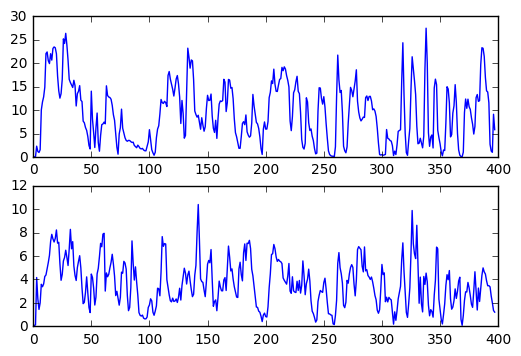

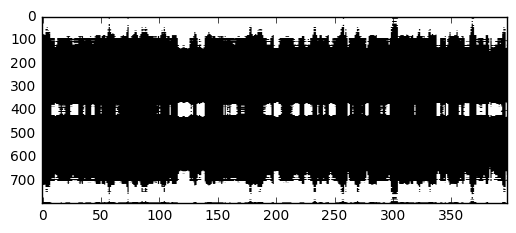

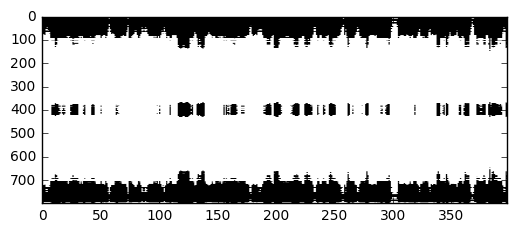

In [4]:
ws = H
masks = np.zeros((len(H),) + sndabft.shape)
for i,wi in enumerate(H):
    ws[i]= wi / np.linalg.norm(wi)
    energyi = ws[i].dot(abs(sndabft).T)
    masks[i] = np.outer( energyi, ws[i] )
    
maska = (masks[0]) > (masks[1])
maskb = (masks[1]) > (masks[0])

plt.figure();
plt.subplot(211); plt.plot( ws[0].dot(abs(sndabft).T)/1e5 )
plt.subplot(212); plt.plot( ws[1].dot(abs(sndabft).T)/1e5 )
plt.figure(); plt.imshow(maska.T, aspect=.2, cmap='bone')
plt.figure(); plt.imshow(maskb.T, aspect=.2, cmap='bone')

In [5]:
sndareconft = maska*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask A
sndarecon = istft( sndareconft, fs, 5, 0.025 )

sndbreconft = maskb*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask B = 1 - A
sndbrecon = istft( sndbreconft, fs, 5, 0.025 )

## Play audio

In [6]:
print('Original signal')
display(Audio(sndab, rate=fs))
print('Reconstruction of signal A')
display(Audio(sndarecon,rate=fs))
print('Reconstruction of signal B')
display(Audio(sndbrecon,rate=fs))

Original signal


Reconstruction of signal A


Reconstruction of signal B
